In [1]:
using Plots; qwt()
default(size=(500,300), leg=false)

# creates x/y vectors which can define a grid in a zig-zag pattern
function gridxy(lim, n::Int)
    xs = linspace(lim..., n)
    xypairs = vec([(x,y) for x in vcat(xs,reverse(xs)), y in xs])
    Plots.unzip(xypairs)
end

gridxy (generic function with 1 method)

# The problem... can we classify the functions?

In [2]:
# these are the functions we want to classify
scalar = 8  # larger is harder... start with 3
f1(x) = 0.6sin(scalar * x) + 0.1
f2(x) = f1(x) - 0.2

# our target function is ∈ {-1,1}
target(f) = f == f1 ? 1.0 : -1.0

target (generic function with 1 method)

# On to the fun...

[Plots.jl] Initializing backend: qwt

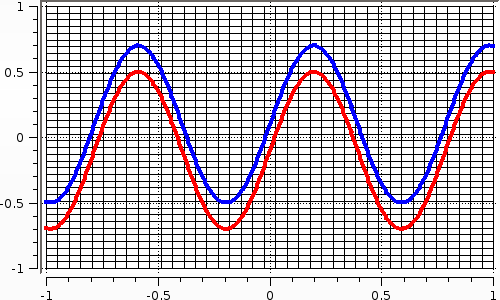

In [3]:
# pick the plotting limits
lim = (-1,1)
funcs = [f1, f2]
n = 40
gridx, gridy = gridxy(lim, n)
default(xlim = lim, ylim = lim)

function initialize_plot(funcs, lim, gridx, gridy; kw...)
    # show the grid
    plot([gridx gridy], [gridy gridx], c=:black; kw...)

    # show the funcs
    plot!(funcs, lim..., l=(4,[:blue :red]))
end

# kick off an animation... we can save frames whenever we want, lets save the starting frame
function initialize_animation()
    anim = Animation()
    frame(anim)
    anim
end

# lets see what we're dealing with...
p = initialize_plot(funcs, lim, gridx, gridy)

# That looks tricky... lets build a neural net!

In [33]:
using OnlineAI

# gradientModel = SGDModel(η=1e-4, μ=0.5)
# gradientModel = AdagradModel(η=1e-2)
gradientModel = AdadeltaModel(η=3e-1, ρ=0.96)

net = buildTanhClassificationNet(
    2,    # number of inputs
    1,    # number of outputs
    [2,2,5,100,5,2,2], # hidden layers structure
    params = NetParams(gradientModel = gradientModel)
)

NeuralNet{
  params: NetParams{OnlineAI.AdadeltaModel(1.0e-6,0.3,0.96,1.0e-5) NoDropout OnlineAI.L2CostModel()}
  solverParams: OnlineAI.SolverParams(1000,1000,10000,-1,[:x,:xhat,:y,:Σ,:a],100,1.0e-5,OnlineAI.donothing)
  layers:
    NormalizedLayer{2=>2 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
    NormalizedLayer{2=>2 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
    NormalizedLayer{2=>5 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
    NormalizedLayer{5=>100 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
    NormalizedLayer{100=>5 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
    NormalizedLayer{5=>2 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
    NormalizedLayer{2=>2 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
    NormalizedLayer{2=>1 OnlineAI.TanhActivation() p=1.0 ‖δΣ‖₁=0.0 ‖δy‖₁=0.0 }
}


# Update our model and the visualization

In [34]:
# set up a visualization of the projections
layers = filter(l -> l.nout == 2, net.layers[1:end-1])
num_hidden_layers = length(layers)
plts = [initialize_plot(funcs, lim, gridx, gridy, title="Hidden Layer $i") for i in 1:num_hidden_layers]
sz = round(Int, sqrt(num_hidden_layers) * 600)
projectionviz = subplot(plts..., n=num_hidden_layers, size=(sz,sz))

# setup animation, then show the plots in a window
anim = initialize_animation()
gui()

# create another visualization to track the internal progress of the neural net
progressviz = track_progress(net, fields=[:w,:b,:Σ,:a], size=(num_hidden_layers*300,800), m=2, w=0);

In [35]:
dist = Distributions.Uniform(lim...)
progressgui = false

function activateHidden(net, layers, x, y, seriesidx, plts)
    n = length(x)
    p = length(plts)
    projx, projy = zeros(n,p), zeros(n,p)
    for i in 1:n
        # feed the data through the neural net
        OnlineAI.forward!(net, [x[i], y[i]])
        
        # grab the net's activations at each layer
        for j in 1:p
            projx[i,j], projy[i,j] = layers[j].a
        end
    end
    
    # now we can update the plots
    for j in 1:p
        plts[j][seriesidx] = (vec(projx[:,j]), vec(projy[:,j]))
    end
end

activateHidden (generic function with 1 method)

In [ ]:
iterations_per_frame = 10000
total_frames = 100
for frm in 1:total_frames
    # pick one of the functions at random, sample from the x line, then update the
    # neural net with [x, f(x)] as the inputs
    for i in 1:iterations_per_frame
        f = sample(funcs)
        x = rand(dist)
        y = target(f)
        update!(net, Float64[x, f(x)], [y])
    end
    
    # update the progress visualization
    update!(progressviz, true, show=progressgui)

    # update the projections
    x = linspace(lim..., 100)
    for (seriesidx, (x,y)) in enumerate([(gridx,gridy), (gridy,gridx), (x,map(f1,x)), (x,map(f2,x))])
        activateHidden(net, layers, x, y, seriesidx, projectionviz.plts)
    end
    
    # show/update the plot
    gui(projectionviz)
    frame(anim)
    sleep(0.001)
end

# displays the progress if there's no gui
progressgui || progressviz.subplt

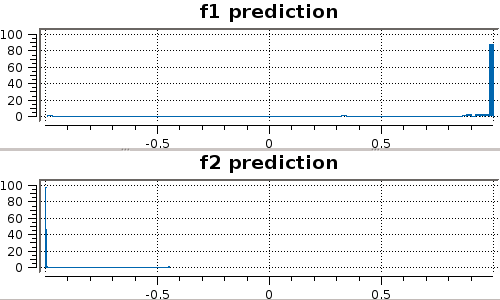

In [31]:
# show stacked and linked histograms of the preditions for each class
testn = 100
xs = linspace(lim..., testn)
x1, x2 = [hcat(xs,map(f,xs)) for f in funcs]
y1, y2 = ones(testn), -ones(testn)
yhat1, yhat2 = [vec(predict(net, x)) for x in (x1,x2)]
subplot(histogram(yhat1), histogram(yhat2), nc=1, linkx=true, title=["f1 prediction", "f2 prediction"])

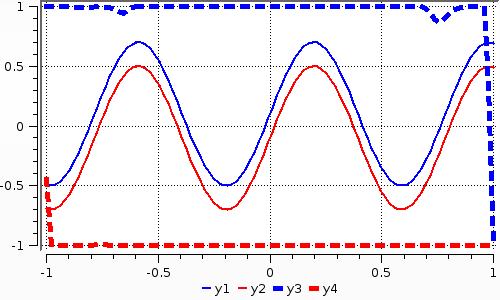

In [32]:
plot(xs, hcat(map(f1,xs), map(f2,xs), yhat1, yhat2), leg=true, line=([2 2 5 5], [:blue :red], [:solid :solid :dot :dot]))

# Animate!

In [ ]:
gif(anim, fps = 20)

# Network viz

In [ ]:
# show the network (uses Qwt, visualize isn't available unless you import it)
import Qwt
viz = visualize(net);

In [ ]:
# update the net representation with weights, etc
update!(viz)

# testing...

In [ ]:
selection[3][2]

In [ ]:
p[4][2] |> length

In [ ]:
gui(progressviz.subplt)

In [ ]:
histogram(yhat1)

In [ ]:
using Plots
p1 = plot(rand(20))
p2 = plot(rand(10))
p3 = scatter(rand(100))
p4 = plot(rand(1000))

In [ ]:
subplot(p1,p2,p3,p4, nr=1, leg=false)

In [ ]:
using Plots; immerse()
p = plot(rand(10))

In [ ]:
gui()

In [ ]:
append!(p,1,rand(10))
gui()

In [ ]:
sp = progressviz.subplt.plts[1].o.widget[:minimumSizeHint]()